1. Задание.
    - Для реализованной в методичке модели градиентного бустинга построить зависимости ошибки от количества деревьев при разных значениях шага градиента на одном графике и для разной глубины деревьев на другом. 
    - Сделать выводы о зависимости ошибки от этих гиперпараметров (шаг градиента, максимальная глубина деревьев, количество деревьев). 
    - Подобрать оптимальные значения этих гиперпараметров (минимум ошибки на тесте при отсутствии переобучения).

2. (\*) Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5.    Сравнить на одном графике кривые  изменения ошибки на тестовой выборке в зависимости от  числа итераций.

3. (\*) Модифицировать алгоритм градиентного бустинга, взяв за основу реализацию решающего дерева из ДЗ_4 (для задачи регрессии). Сделать выводы о качестве алгоритма по сравнению с реализацией из п.1.

In [2]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import random

from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

import numpy as np

**Реализация для задачи №3**

In [3]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [4]:
class Leaf:
    
    def __init__(self, data, labels, classification=True):  # добавлен параметр для реализации задачи регрессии
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        return np.mean(self.labels)   

In [5]:
# Для задачи №3

class MyDecisionTreeRegressor:
    def __init__(self, max_depth=np.inf, min_leaf=3):
        self.max_depth = max_depth
        self.min_leaf = min_leaf
        self.tree = None
    
    def quality(self, left_labels, right_labels, current_criteria):
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

        return current_criteria - p * np.var(left_labels) - (1 - p) * np.var(right_labels)
    
    def split(self, data, labels, index, t):
    
        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)

        true_data = data[left]
        false_data = data[right]
        true_labels = labels[left]
        false_labels = labels[right]

        return true_data, false_data, true_labels, false_labels
    
    def find_best_split(self, data, labels):

        current_criteria = np.var(labels)

        best_quality = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        for index in range(n_features):
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique([row[index] for row in data])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < self.min_leaf or len(false_data) < self.min_leaf:
                    continue

                current_quality = self.quality(true_labels, false_labels, current_criteria)

                #  выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index
    
    def build_tree(self, data, labels, depth=0):

        #  Базовый случай по макс.глубине для узлов (корень = 0я глубина)
        if depth == self.max_depth:
            return Leaf(data, labels)

        quality, t, index = self.find_best_split(data, labels)

        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
        if quality == 0:
            return Leaf(data, labels)

        true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        true_branch = self.build_tree(true_data, true_labels, depth+1)
        false_branch = self.build_tree(false_data, false_labels, depth+1)

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        return Node(index, t, true_branch, false_branch)
    
    def fit(self, data, targets):
        self.tree = self.build_tree(data, targets)
    
    def classify_object(self, obj, node):
        if isinstance(node, Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self.classify_object(obj, node.true_branch)
        else:
            return self.classify_object(obj, node.false_branch)
        
    def predict(self, data):
        preds = []
        for obj in data:
            prediction = self.classify_object(obj, self.tree)
            preds.append(prediction)
        return preds

**Задачи:**

In [6]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [8]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании 
    # прибавляются с шагом eta
    return np.array([sum([
        eta * coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) 
                     for x in X])

In [9]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction) ** 2)) / len(y_real)

In [10]:
def bias(y, z):
    return - 2 * (z - y)

In [11]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, 
           is_stohastic=False, sub_size=0.5,  # Для стохастического градиентного бустинга
           min_leaf=3, is_MDTR=False  # для собственного регрессора
          ): 
    
    # eta - скорость обучения
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        if is_MDTR:
            tree = MyDecisionTreeRegressor(max_depth=max_depth, min_leaf=min_leaf)
        else:
            tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            sub_X_train = X_train
            sub_y_train = y_train
            
            if is_stohastic:
                n_samples = X_train.shape[0]
                n_sub_samples = round(n_samples * sub_size)
                indices = random.sample(range(n_samples), n_sub_samples)
                sub_X_train = X_train[indices]
                sub_y_train = y_train[indices]
            
            # Получим ответы на текущей композиции
            z_train = gb_predict(sub_X_train, trees, coefs, eta)
            
            # алгоритмы, начиная со второго, обучаем на сдвиг
            tree.fit(sub_X_train, bias(sub_y_train, z_train))
            
            train_errors.append(mean_squared_error(sub_y_train, gb_predict(sub_X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [12]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {round(mean_squared_error(y_train, train_prediction))}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {round(mean_squared_error(y_test, test_prediction))}')

In [13]:
def get_error_plot(n_trees, train_err, test_err, label=''):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    examples = len(train_err)
    for i in range(examples):
        plt.plot(list(range(1, n_trees+1)), train_err[i], label=label[0][i])
        plt.plot(list(range(1, n_trees+1)), test_err[i], label=label[1][i])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [18]:
# Число деревьев в ансамбле
n_trees = 25

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

depths = [2, 3, 5, 6]
ldepths = [[f'train error for max_depth = {el}' for el in depths],
           [f'test error for max_depth = {el}' for el in depths]]

etas = [0.1, 0.05, 0.01]
letas = [[f'train error for eta = {el}' for el in etas],
           [f'test error for eta = {el}' for el in etas]]

In [15]:
max_depth = 3
train_errs = []
test_errs = []
for eta in etas:
    trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    train_errs.append(train_errors)
    test_errs.append(test_errors)
    print(f'eta = {eta}: ')
    evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

eta = 0.1: 
Ошибка алгоритма из 25 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 1356
Ошибка алгоритма из 25 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 3210
eta = 0.05: 
Ошибка алгоритма из 25 деревьев глубиной 3     с шагом 0.05 на тренировочной выборке: 2104
Ошибка алгоритма из 25 деревьев глубиной 3     с шагом 0.05 на тестовой выборке: 2993
eta = 0.01: 
Ошибка алгоритма из 25 деревьев глубиной 3     с шагом 0.01 на тренировочной выборке: 12846
Ошибка алгоритма из 25 деревьев глубиной 3     с шагом 0.01 на тестовой выборке: 11555


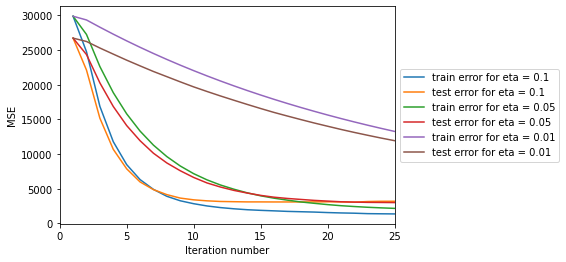

In [16]:
get_error_plot(n_trees, train_errs, test_errs, letas)

**Вывод:** На достаточно больших eta заметно переобучение. При уменьшении eta до некоторых оптимальных значений переобучение пропадает, и достигается минимальная ошибка на тестовых данных. При дальнейшем уменьшении eta требуется всё больше итераций для достижения приемлемых значений ошибки (недообучение).

In [19]:
eta = 0.05
train_errs = []
test_errs = []
for max_depth in depths:
    trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    train_errs.append(train_errors)
    test_errs.append(test_errors)
    print(f'max_depth = {max_depth}: ')
    evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

max_depth = 2: 
Ошибка алгоритма из 25 деревьев глубиной 2     с шагом 0.05 на тренировочной выборке: 2692
Ошибка алгоритма из 25 деревьев глубиной 2     с шагом 0.05 на тестовой выборке: 2992
max_depth = 3: 
Ошибка алгоритма из 25 деревьев глубиной 3     с шагом 0.05 на тренировочной выборке: 2104
Ошибка алгоритма из 25 деревьев глубиной 3     с шагом 0.05 на тестовой выборке: 2993
max_depth = 5: 
Ошибка алгоритма из 25 деревьев глубиной 5     с шагом 0.05 на тренировочной выборке: 889
Ошибка алгоритма из 25 деревьев глубиной 5     с шагом 0.05 на тестовой выборке: 3614
max_depth = 6: 
Ошибка алгоритма из 25 деревьев глубиной 6     с шагом 0.05 на тренировочной выборке: 513
Ошибка алгоритма из 25 деревьев глубиной 6     с шагом 0.05 на тестовой выборке: 3292


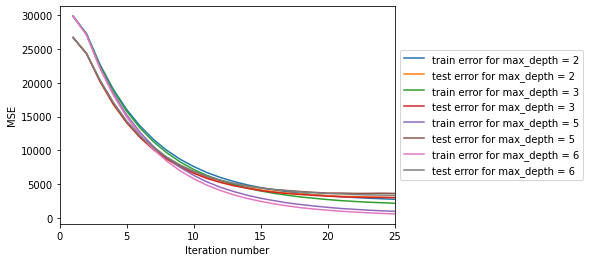

In [20]:
get_error_plot(n_trees, train_errs, test_errs, ldepths)

**Выводы:** При увеличении глубины дерева растёт переобучение.

В качестве оптимальных параметров, исходя из полученных результатов, выбираем для eta - 0.05, для max_depth - 2 и 3 (проверим с другими алгоритмами для этих двух значений отдельно: для глубины 3 начинает проявляться переобучение, но не слишком).

In [21]:
# Проверяем разные алгоритмы на оптимальных параметрах
best_eta = 0.05
best_depth = 2
print(f'eta = {best_eta}, max_depth = {best_depth}:')
train_errs = []
test_errs = []
algs = ['DTR', 'SGB', 'my DTR']
labels = [[f'train error for {alg}' for alg in algs],
          [f'test error for {alg}' for alg in algs]]

trees, train_errors, test_errors = gb_fit(n_trees, best_depth, X_train, X_test, y_train, y_test, coefs, best_eta)
train_errs.append(train_errors)
test_errs.append(test_errors)
print('С использованием DecisionTreeRegressor: ')
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

trees, train_errors, test_errors = gb_fit(n_trees, best_depth, X_train, X_test, y_train, y_test, coefs, best_eta,
                                             is_stohastic=True)
train_errs.append(train_errors)
test_errs.append(test_errors)
print('SGB: ')
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

trees, train_errors, test_errors = gb_fit(n_trees, best_depth, X_train, X_test, y_train, y_test, coefs, best_eta,
                                         is_MDTR=True)
train_errs.append(train_errors)
test_errs.append(test_errors)
print('С использованием дерева решений для регрессии: ')
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

eta = 0.05, max_depth = 2:
С использованием DecisionTreeRegressor: 
Ошибка алгоритма из 25 деревьев глубиной 6     с шагом 0.05 на тренировочной выборке: 2692
Ошибка алгоритма из 25 деревьев глубиной 6     с шагом 0.05 на тестовой выборке: 2992
SGB: 
Ошибка алгоритма из 25 деревьев глубиной 6     с шагом 0.05 на тренировочной выборке: 2640
Ошибка алгоритма из 25 деревьев глубиной 6     с шагом 0.05 на тестовой выборке: 2813
С использованием дерева решений для регрессии: 
Ошибка алгоритма из 25 деревьев глубиной 6     с шагом 0.05 на тренировочной выборке: 2703
Ошибка алгоритма из 25 деревьев глубиной 6     с шагом 0.05 на тестовой выборке: 2978


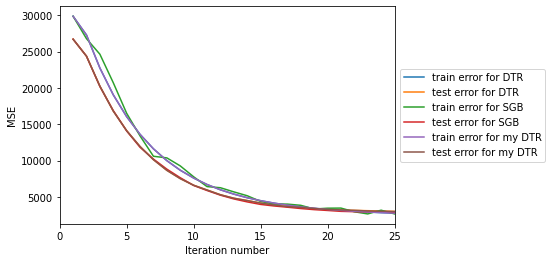

In [22]:
get_error_plot(n_trees, train_errs, test_errs, labels)

In [23]:
# Проверяем разные алгоритмы на оптимальных параметрах
best_eta = 0.05
best_depth = 3
print(f'eta = {best_eta}, max_depth = {best_depth}:')
train_errs = []
test_errs = []
algs = ['DTR', 'SGB', 'my DTR']
labels = [[f'train error for {alg}' for alg in algs],
          [f'test error for {alg}' for alg in algs]]

trees, train_errors, test_errors = gb_fit(n_trees, best_depth, X_train, X_test, y_train, y_test, coefs, best_eta)
train_errs.append(train_errors)
test_errs.append(test_errors)
print('С использованием DecisionTreeRegressor: ')
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

trees, train_errors, test_errors = gb_fit(n_trees, best_depth, X_train, X_test, y_train, y_test, coefs, best_eta,
                                             is_stohastic=True)
train_errs.append(train_errors)
test_errs.append(test_errors)
print('SGB: ')
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

trees, train_errors, test_errors = gb_fit(n_trees, best_depth, X_train, X_test, y_train, y_test, coefs, best_eta,
                                         is_MDTR=True)
train_errs.append(train_errors)
test_errs.append(test_errors)
print('С использованием дерева решений для регрессии: ')
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

eta = 0.05, max_depth = 3:
С использованием DecisionTreeRegressor: 
Ошибка алгоритма из 25 деревьев глубиной 6     с шагом 0.05 на тренировочной выборке: 2104
Ошибка алгоритма из 25 деревьев глубиной 6     с шагом 0.05 на тестовой выборке: 2993
SGB: 
Ошибка алгоритма из 25 деревьев глубиной 6     с шагом 0.05 на тренировочной выборке: 2162
Ошибка алгоритма из 25 деревьев глубиной 6     с шагом 0.05 на тестовой выборке: 2901
С использованием дерева решений для регрессии: 
Ошибка алгоритма из 25 деревьев глубиной 6     с шагом 0.05 на тренировочной выборке: 2110
Ошибка алгоритма из 25 деревьев глубиной 6     с шагом 0.05 на тестовой выборке: 3041


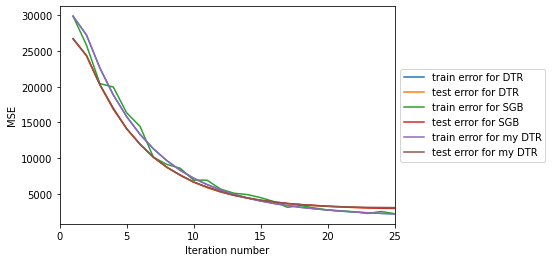

In [24]:
get_error_plot(n_trees, train_errs, test_errs, labels)

**Выводы:** все три варианта показали примерно одинаковые результаты, стохастический был чуть лучше, а также быстрее (это было ожидаемо).